# Preparing the environment

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

The Seaborn library provides easy-to-use plotting functions for common plot types, and better default visual styles.

In [2]:
import seaborn as sea

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 7)

sea.set_style('dark')

## SQL database connection

The ESC493 VM comes preinstalled with [Catherine Devlin's `%sql`-magic for IPython][1]; this allows you to run SQL queries from the IPython notebook, and intermix them with Python code.

[1]: https://github.com/catherinedevlin/ipython-sql

Before we can use the `%sql` syntax, two steps must be taken:

* Load the IPython-SQL bridge code

In [45]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


* Connect to an actual database; this must be the first `%sql` statement (the `rmurri@/lustre` syntax means "connect to the PostGreSQL DB named `lustre` running on *this* host as user `rmurri`" -- of course change `rmurri` to *your* user name):

In [46]:
%sql postgresql://chrble@/lustre


u'Connected: chrble@lustre'

Now you can run 1-line SQL queries by prefixing them with `%sql` or multi-line ones with `%%sql`

# Exploring the dataset

In [6]:
%sql select * from lustre limit 5;

5 rows affected.


usr,grp,atime,mtime,blksize,size,path
usr388,i5105,1384452271,1384452271,4,2203,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00170060_dock014.pdb
usr388,i5105,1384452311,1384452311,4,1708,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00171011_dock014.pdb
usr388,i5105,1384452490,1384452490,4,1213,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00174084_dock006.pdb
usr388,i5105,1384452674,1384452674,4,1488,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00179374_dock004.pdb
usr388,i5105,1384453267,1384453267,4,1708,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00205410_dock007.pdb


The `%sql` "magic" can also be used as an expression: it returns the result table as a Python `list` of tuples:

In [7]:
%%time

result = %sql select size, count(path) from lustre_sample group by size order by size asc limit 100;

100 rows affected.
CPU times: user 2.72 ms, sys: 423 µs, total: 3.15 ms
Wall time: 1.77 s


Now the `result` list can be used in code as if we had defined it in Python directly:

In [8]:
result[:5]

[(0L, 12722L), (1L, 15L), (2L, 20L), (3L, 2L), (4L, 43L)]

## Plotting results

In order to plot results, we need to have separate lists/arrays for the X-axis values and the corresponding Y-axis values.


Python's `zip` function is used to split the result table into independent lists (all first elements, all second elements):

In [9]:
sizes, occurrences = zip(*result)

In [10]:
sizes[:5], occurrences[:5]

((0L, 1L, 2L, 3L, 4L), (12722L, 15L, 20L, 2L, 43L))

The `plt.plot()` function is used to make a line plot; here we show how to place "sizes" on the X-axis and "occurrences" on the Y-axis:

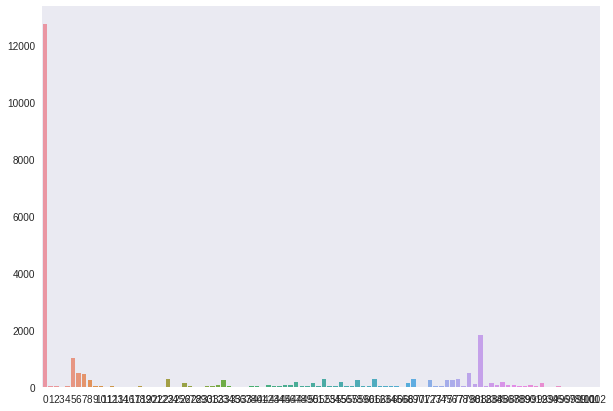

In [20]:
sea.barplot(sizes, occurrences)

---

## 1. Plot distribution by block size

Plot the number of files of a certain *block size* (column `blksize`).  The *block size* is the actual size allocated on the disk, measured in blocks (size depends on the filesystem -- here 1 block is 1MB).

In [71]:
blk_sizes = %sql SELECT count(blksize),blksize FROM lustre_sample GROUP BY blksize ORDER BY count DESC LIMIT 15;

15 rows affected.


In [72]:
blk_sizes[:5]

[(819230L, 4), (118067L, 8), (65621L, 40), (59417L, 36), (33592L, 32)]

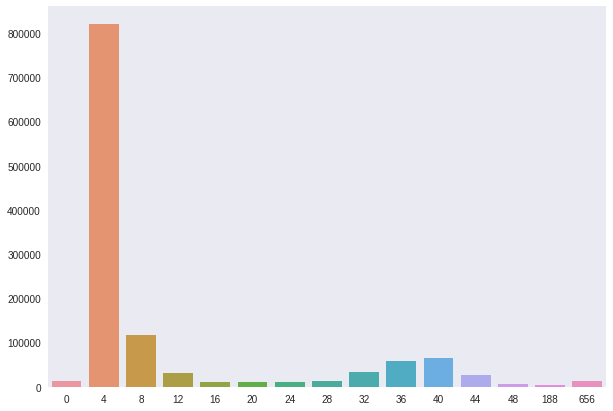

In [73]:
sizes,occurences = zip(*blk_sizes)
sea.barplot(occurences, sizes)

## 2. Plot number of users by number of (owned) files

For each user *u*, let *N(u)* be the number of files owned by user *u*.  For each integer *K*, compute and plot the number of users *u* such that *N(u) = K*.

In [60]:
blk_sizes = %sql SELECT count(usr),file_count FROM (SELECT count(usr) as file_count,usr FROM lustre_sample GROUP BY usr) as usrs GROUP BY file_count;

40 rows affected.


In [62]:
blk_sizes[:5]

[(1L, 129L), (1L, 34L), (1L, 1865L), (1L, 1L), (1L, 666L)]

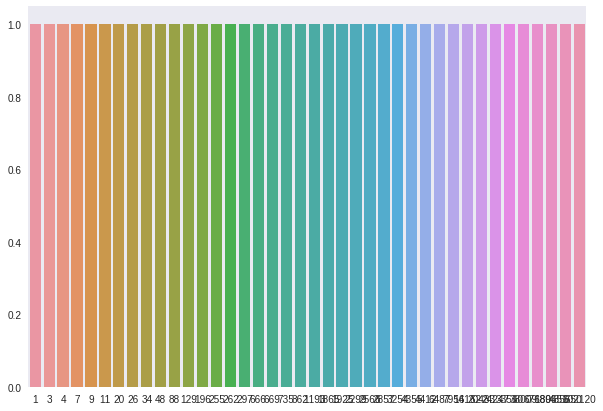

In [64]:
num_users,num_files = zip(*blk_sizes)
sea.barplot(num_files,num_users )

In [78]:
import numpy as np

hist,bin_edges = np.histogram(num_files)

In [79]:
sea.barplot(hist,bin_edges)

AssertionError: Grouper and axis must be same length

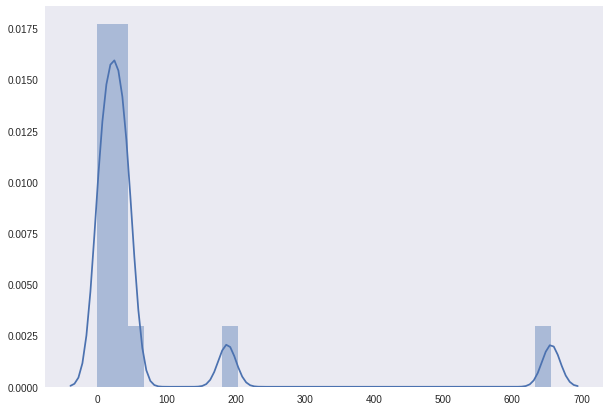

In [80]:
sea.distplot(np.array(num_files))